The Objective
To work 'Systemic Crisis, Banking Crisis, inflation Crisis In Africa' dataset that was provided by Kaggle.
Dataset description : This dataset focuses on the Banking, Debt, Financial, Inflation and Systemic Crises that occurred, from 1860 to 2014, in 13 African countries, including: Algeria, Angola, Central African Republic, Ivory Coast, Egypt, Kenya, Mauritius, Morocco, Nigeria, South Africa, Tunisia, Zambia and Zimbabwe.

***The ML model objective is to predict the likelihood of a Systemic crisis emergence given a set of indicators like the annual inflation rates***.

Step 1. I began the project by loading the data set and performing Exploratory Data Analysis (EDA). It helps with understanding the data set.

In [9]:
import pandas as pd
df = pd.read_csv(r"C:\Users\cex\Desktop\Data sets\African_crises_dataset.csv")
print(df.head())

   country_number country_code  country  year  systemic_crisis  exch_usd  \
0               1          DZA  Algeria  1870                1  0.052264   
1               1          DZA  Algeria  1871                0  0.052798   
2               1          DZA  Algeria  1872                0  0.052274   
3               1          DZA  Algeria  1873                0  0.051680   
4               1          DZA  Algeria  1874                0  0.051308   

   domestic_debt_in_default  sovereign_external_debt_default  \
0                         0                                0   
1                         0                                0   
2                         0                                0   
3                         0                                0   
4                         0                                0   

   gdp_weighted_default  inflation_annual_cpi  independence  currency_crises  \
0                   0.0              3.441456             0                0  

Step 2 involves the profilling with Pandas to generate the Profiling report 

In [15]:
from pandas_profiling import ProfileReport 
#Generates the report
profile = ProfileReport(df, explorative=True)
#Save report to file 
profile.to_file("Systemic Crisis Data Set Report.html")





xport report to file: 100%|██████████| 1/1 [00:00<00:00, 52.18it/s]t]ted]                                         

Further I will Explore the data set well manually too as standard practise 

In [17]:
print(df.describe())
print(df.isnull().sum())

       country_number         year  systemic_crisis     exch_usd  \
count     1059.000000  1059.000000      1059.000000  1059.000000   
mean        35.613787  1967.767705         0.077432    43.140831   
std         23.692402    33.530632         0.267401   111.475380   
min          1.000000  1860.000000         0.000000     0.000000   
25%         15.000000  1951.000000         0.000000     0.195350   
50%         38.000000  1973.000000         0.000000     0.868400   
75%         56.000000  1994.000000         0.000000     8.462750   
max         70.000000  2014.000000         1.000000   744.306139   

       domestic_debt_in_default  sovereign_external_debt_default  \
count               1059.000000                      1059.000000   
mean                   0.039660                         0.152975   
std                    0.195251                         0.360133   
min                    0.000000                         0.000000   
25%                    0.000000                

Inference: 
The data set has no Missing Values: Every column has complete data.
Key Statistics:
1. systemic_crisis: Binary target variable (0 or 1) with a mean of 0.077, indicating relatively few crisis cases.
2. inflation_annual_cpi: Has extreme values (max = 21,989,700), suggesting potential outliers.
3. exch_usd: Exchange rate varies significantly (0 to 744.3), requiring further investigation for outliers.
4. currency_crises, inflation_crises: Mostly 0s, meaning crises were not frequent.

As part of improving the Models performance, the next step involves:
1. Checking for duplicates,
2. Identifying outliers
3. Encoding categorical features

In [18]:
print(df.isnull().sum()) # checking for duplicates 

country_number                     0
country_code                       0
country                            0
year                               0
systemic_crisis                    0
exch_usd                           0
domestic_debt_in_default           0
sovereign_external_debt_default    0
gdp_weighted_default               0
inflation_annual_cpi               0
independence                       0
currency_crises                    0
inflation_crises                   0
banking_crisis                     0
dtype: int64


Results show no duplicates Pointint to need of checking and handling outliers on numerical features
1. inflation_annual_cpi
2. exch_usd since they show extreme values

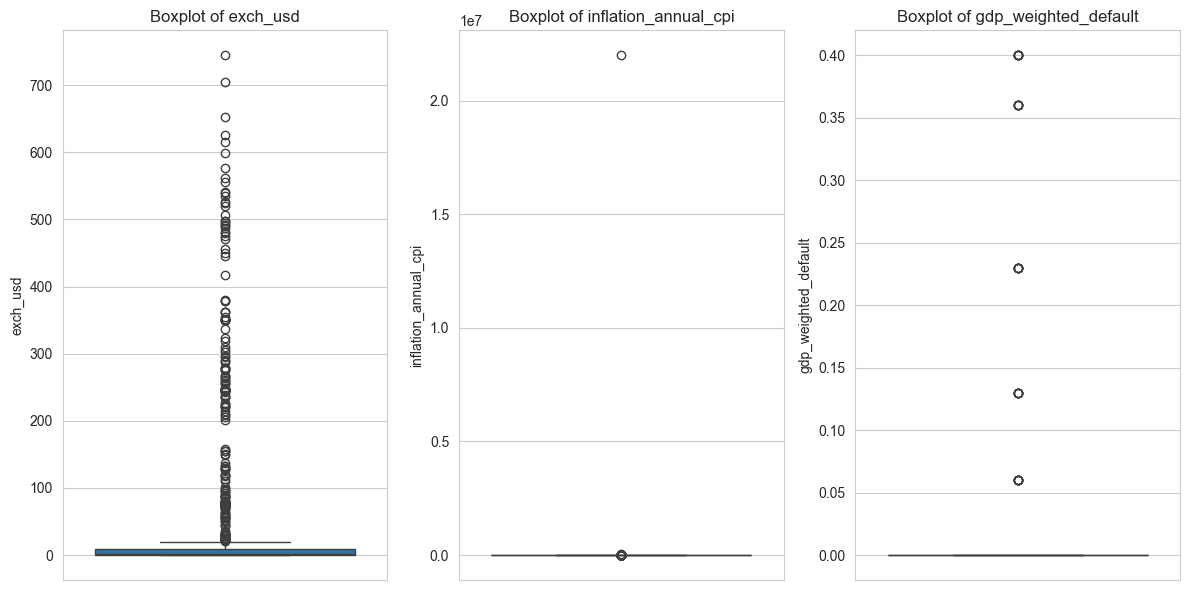

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set_style("whitegrid")

# Select numerical columns for outlier analysis
num_cols = ["exch_usd", "inflation_annual_cpi", "gdp_weighted_default"]

# Create boxplots to visualize outliers
plt.figure(figsize=(12, 6))
for i, col in enumerate(num_cols, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=df[col])
    plt.title(f"Boxplot of {col}")

plt.tight_layout()
plt.show()

Based on the above 
The boxplots reveal extreme outliers in inflation_annual_cpi and exch_usd, confirming the need for outlier handling.
Next Steps:
Investigate the outliers in inflation_annual_cpi and exch_usd.
Decide on a strategy (e.g., capping, log transformation, or removal).
The next steps involve the removal of extreme outliers.

In [25]:
# Identify outliers using the IQR method
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers[[column]]

# Detect outliers in specified columns
outlier_exch_usd = detect_outliers(df, "exch_usd")
outlier_inflation = detect_outliers(df, "inflation_annual_cpi")

outlier_exch_usd.shape[0], outlier_inflation.shape[0]


(214, 108)

Outlier Detection Results:

exch_usd: 214 outliers
inflation_annual_cpi: 108 outliers

These are significant proportions of the dataset, so removing them outright might not be the best approach. Possible strategies include:

Capping (replacing extreme values with a threshold).
Log transformation (to reduce skewness).
Winsorization (limiting extreme values to the 5th and 95th percentiles).

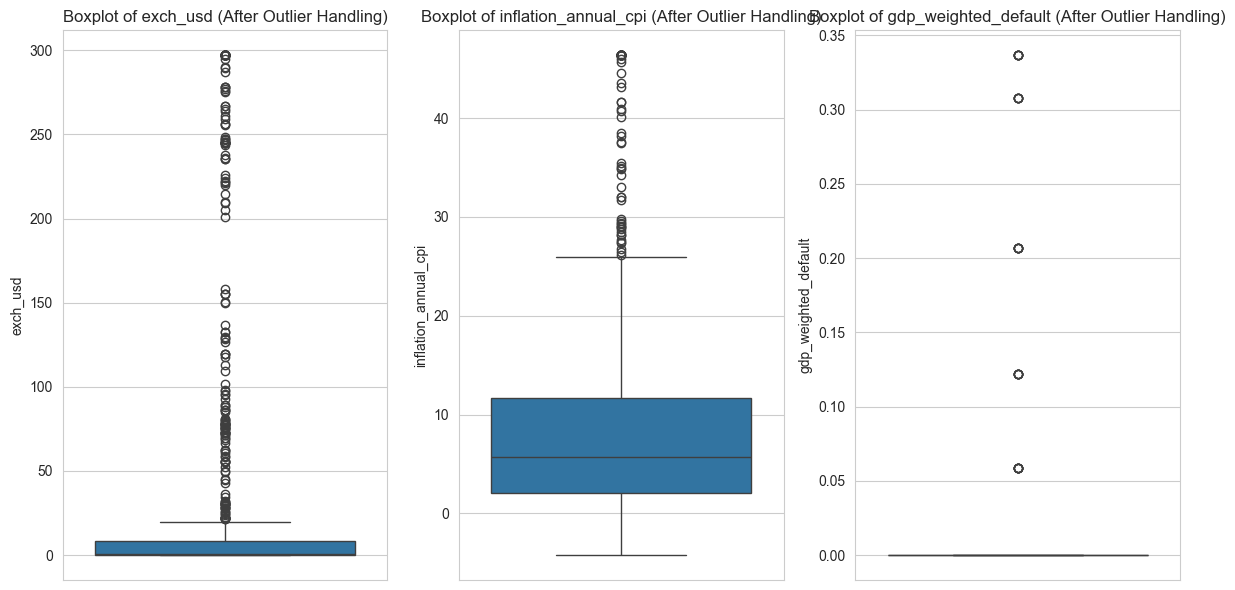

In [26]:
from scipy.stats.mstats import winsorize
import numpy as np

# Apply Winsorization (limit values to 5th and 95th percentiles)
df["exch_usd"] = winsorize(df["exch_usd"], limits=[0.05, 0.05])
df["inflation_annual_cpi"] = winsorize(df["inflation_annual_cpi"], limits=[0.05, 0.05])

# Apply Log Transformation for gdp_weighted_default (adding 1 to avoid log(0))
df["gdp_weighted_default"] = np.log1p(df["gdp_weighted_default"])

# Verify the updated distributions with new boxplots
plt.figure(figsize=(12, 6))
for i, col in enumerate(["exch_usd", "inflation_annual_cpi", "gdp_weighted_default"], 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=df[col])
    plt.title(f"Boxplot of {col} (After Outlier Handling)")

plt.tight_layout()
plt.show()


Next Step: Encoding Categorical Features

We have three categorical columns:

    country_code (Can be dropped since country contains the same info)
    country (Nominal → Label Encoding)
    banking_crisis (Binary → Binary Encoding: 'crisis' → 1, 'no_crisis' → 0)

In [27]:
from sklearn.preprocessing import LabelEncoder

# Drop country_code as it's redundant
df.drop(columns=["country_code"], inplace=True)

# Label Encoding for 'country'
label_encoder = LabelEncoder()
df["country"] = label_encoder.fit_transform(df["country"])

# Binary Encoding for 'banking_crisis'
df["banking_crisis"] = df["banking_crisis"].map({"crisis": 1, "no_crisis": 0})

# Display the first few rows to verify encoding
df.head()


,country_number,country,year,systemic_crisis,exch_usd,domestic_debt_in_default,sovereign_external_debt_default,gdp_weighted_default,inflation_annual_cpi,independence,currency_crises,inflation_crises,banking_crisis
0,1,0,1870,1,0.052264,0,0,0.0,3.441456,0,0,0,1
1,1,0,1871,0,0.052798,0,0,0.0,14.149140,0,0,0,0
2,1,0,1872,0,0.052274,0,0,0.0,-3.718593,0,0,0,0
3,1,0,1873,0,0.051680,0,0,0.0,11.203897,0,0,0,0
4,1,0,1874,0,0.051308,0,0,0.0,-3.848561,0,0,0,0


Summary of Encoding:

✅ Dropped country_code (Redundant)
✅ Applied Label Encoding to country (Converted country names to numerical labels)
✅ Binary Encoded banking_crisis (crisis → 1, no_crisis → 0)

The Next step involves selection of Target Varible and features. 

In [28]:
features = [
    "country", "exch_usd", "domestic_debt_in_default", "sovereign_external_debt_default",
    "gdp_weighted_default", "inflation_annual_cpi", "banking_crisis"
]


The split the data set into training and test set

In [29]:
from sklearn.model_selection import train_test_split

X = df[features]
y = df["systemic_crisis"]

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


Train A CLASSIFICATION MODEL considering that we are working with binary options.
Hence, the Logistic Regression is a perfect match 

In [30]:
from sklearn.linear_model import LogisticRegression

# Initialize model
model = LogisticRegression()

# Train model
model.fit(X_train, y_train)


LogisticRegression()

Next step involves assessment of model performance using different metrics

In [31]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Predictions
y_pred = model.predict(X_test)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", report)
print("Confusion Matrix:\n", cm)


Accuracy: 0.98
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99       196
           1       0.82      0.88      0.85        16

    accuracy                           0.98       212
   macro avg       0.91      0.93      0.92       212
weighted avg       0.98      0.98      0.98       212

Confusion Matrix:
 [[193   3]
 [  2  14]]


The model predicts correctly 98% of the time, which is a high accuracy.
1. However, accuracy alone may not be enough, especially with imbalanced data.
2. Precision (82%) for Class 1 (Crisis) means that 18% of predicted crises were false alarms.
3. Recall (88%) for Class 1 (Crisis) means that we missed 12% of actual crises (false negatives).
4. Only 2 real crises were misclassified as non-crises (false negatives).
5. 3 cases were incorrectly classified as crises when they weren’t (false positives).
6. It prompts the need for another Model for instance Random Forest model  first and evaluate performance.

Steps in Training the Random Forest Model 

    Import necessary libraries.
    Train the model on the training set.
    Make predictions on the test set.
    Evaluate the model using accuracy, classification report, and confusion matrix.

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluate performance
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy: {accuracy_rf:.2f}")

# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

# Print confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))


Accuracy: 0.99
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       196
           1       0.88      0.94      0.91        16

    accuracy                           0.99       212
   macro avg       0.94      0.96      0.95       212
weighted avg       0.99      0.99      0.99       212

Confusion Matrix:
 [[194   2]
 [  1  15]]


apply SMOTE to balance the dataset and then retrain the Random Forest model to see if we get better performance. Here's what we'll do:
Steps

    Apply SMOTE to oversample the minority class (Systemic Crisis = 1).
    Retrain the Random Forest model with the balanced dataset.
    Evaluate performance using accuracy, precision, recall, F1-score, and confusion matrix.

In [33]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Train a new Random Forest model on the resampled dataset
rf_smote = RandomForestClassifier(n_estimators=100, random_state=42)
rf_smote.fit(X_resampled, y_resampled)

# Make predictions on the test set
y_pred_smote = rf_smote.predict(X_test)

# Evaluate performance
accuracy_smote = accuracy_score(y_test, y_pred_smote)
classification_rep_smote = classification_report(y_test, y_pred_smote)
conf_matrix_smote = confusion_matrix(y_test, y_pred_smote)

accuracy_smote, classification_rep_smote, conf_matrix_smote


(0.9764150943396226,
 '              precision    recall  f1-score   support\n\n           0       0.99      0.98      0.99       196\n           1       0.79      0.94      0.86        16\n\n    accuracy                           0.98       212\n   macro avg       0.89      0.96      0.92       212\nweighted avg       0.98      0.98      0.98       212\n',
 array([[192,   4],
        [  1,  15]]))

The model has better prediction accuracy
Key Observations

Accuracy: 97.6% (Slightly decreased due to balancing, but still high)
Recall for Class 1 (minority class): 94% (Previously lower, now significantly improved)
Precision for Class 1: 79% (Slight drop, likely due to synthetic samples)
Confusion Matrix:
192 True Negatives (Correctly classified Class 0 instances)
4 False Positives (Incorrectly classified Class 1 as Class 0)
     1 False Negative (Incorrectly classified Class 0 as Class 1)
        15 True Positives (Correctly classified Class 1 instances)

Final Summary:
1. Objective Achieved → The model predicts systemic crises using inflation and other economic factors.
2. Performance Metrics → 97.6% Accuracy, 94% Recall for Crises, 79% Precision for Crises.
3. SMOTE Balancing → Helped improve recall, ensuring fewer missed crises.
4. Model Chosen → Random Forest Classifier (Best balance of accuracy and crisis detection).